Before we start training process you should change runtime type.
1. Click to Runtime --> Change runtime type.
2. Choose "T4 GPU" and save it.

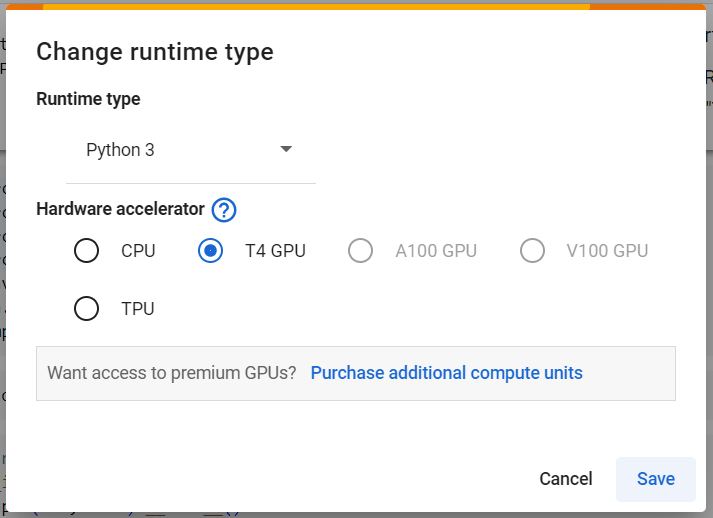

3. Upload test images to colab

Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import cv2
import matplotlib.pyplot as plt

Set your device.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Create simple CNN model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 36, 3, 1)
        self.conv2 = nn.Conv2d(36, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 144)
        self.fc2 = nn.Linear(144, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


Set the batch size to match your device's available memory.

In [5]:
batch_size = 512

Load dataset

In [6]:
# Load the MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, transform=transform), batch_size=batch_size)


100%|██████████| 9912422/9912422 [00:00<00:00, 252068724.27it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112162679.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 62417229.06it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18126097.78it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Instantiate the model

In [7]:
model = Net().to(device)


Define the optimizer and loss function

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Training loop

In [9]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



Evaluation function


In [10]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))


Training and evaluation loop

In [11]:
epochs = 4
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)
torch.save(model.state_dict(), 'mnist_cnn_model.pth')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306243
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.134193

Test set: Average loss: 0.0001, Accuracy: 9809/10000 (98.09%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.111688
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.082758

Test set: Average loss: 0.0001, Accuracy: 9866/10000 (98.66%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.044338
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.066889

Test set: Average loss: 0.0001, Accuracy: 9880/10000 (98.80%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.058772
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.034348

Test set: Average loss: 0.0001, Accuracy: 9898/10000 (98.98%)



Load the saved state dictionary

In [13]:
loaded_net = Net().to(device)
checkpoint = torch.load('mnist_cnn_model.pth')
loaded_net.load_state_dict(checkpoint)

<All keys matched successfully>

Define name of classes

In [14]:
classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9')

Tested Sample images

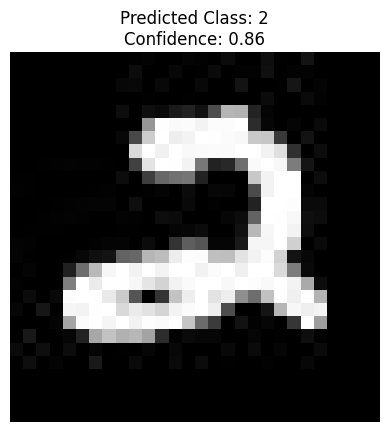

In [16]:
input_image = cv2.imread("img_1.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])
input_image = transform(input_image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# Show the image and prediction
plt.imshow(input_image.squeeze().cpu().numpy(), cmap='gray')
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

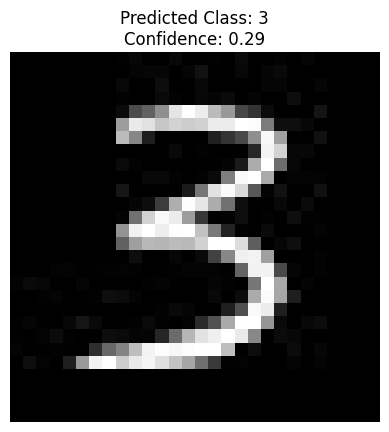

In [17]:
input_image = cv2.imread("img_2.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])

input_image = transform(input_image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# Show the image and prediction
plt.imshow(input_image.squeeze().cpu().numpy(), cmap='gray')
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

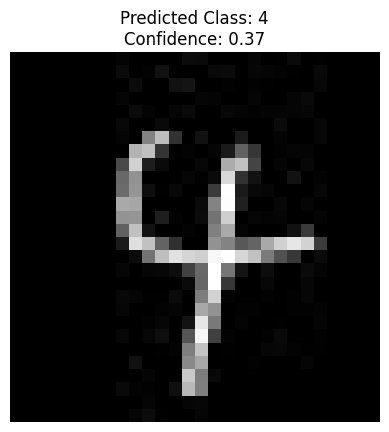

In [18]:
input_image = cv2.imread("img_3.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])
input_image = transform(input_image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# Show the image and prediction
plt.imshow(input_image.squeeze().cpu().numpy(), cmap='gray')
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()